In [1]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
import matplotlib
import os
#import h5py
import PseudoNetCDF as pnc
from scipy.ndimage import label
import scipy.interpolate as interp
import pickle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
from scipy.integrate import cumulative_trapezoid as scitrapz

In [2]:
#=======================================
# Diagnostics Parameters
#=======================================
space = '    '
#=======================================
# Functions
#=======================================
def print_diag(key,var):
    print(key)
    print(space,'Shape:',np.shape(var))
    print(space,'Max:',np.max(var))
    print(space,'Min:',np.min(var))
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

# Read in Learjet cloud pass dictionary (created using script for Fig. D1)

In [3]:
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/cloud_passes/'
file = path+'camp2ex_learjet_20190925_cloud_pass_dict_paper_v2.p'
learjet_dict = pickle.load(open(file,"rb"))

lj_mean_temps = []
lj_min_temps = []
lj_max_temps = []
lj_mean_w = []
lj_std_w = []
lj_max_w = []
lj_min_w = []
lj_keys = []
lj_mean_lwc = []
lj_max_lwc = []
lj_transect_length = []
lj_cloud_pass_id = []
lj_mean_alts = []
lj_samp_size = []

for key in learjet_dict.keys():
    tmp_mean_temp = learjet_dict[key]['bulk_dict']['mean_temp']
    tmp_min_temp = learjet_dict[key]['bulk_dict']['min_temp']
    tmp_max_temp = learjet_dict[key]['bulk_dict']['max_temp']
    tmp_mean_w = learjet_dict[key]['bulk_dict']['mean_w']
    tmp_mean_alts = np.mean(learjet_dict[key]['bulk_dict']['alt'])
    tmp_max_w = learjet_dict[key]['bulk_dict']['max_w']
    tmp_min_w = learjet_dict[key]['bulk_dict']['min_w']
    tmp_w = learjet_dict[key]['bulk_dict']['w']
    tmp_std_w = np.std(tmp_w)
    lj_std_w.append(tmp_std_w)
    tmp_mean_lwc = learjet_dict[key]['bulk_dict']['mean_NevLWC']
    tmp_max_lwc = learjet_dict[key]['bulk_dict']['max_NevLWC']
    tmp_tas = learjet_dict[key]['bulk_dict']['tas'] # m/s
    len_transect = np.sum(tmp_tas)*1.e-3 # since each sample is 1 second, only need to to sum to ket transect length and then convert to km for convenience
    lj_transect_length.append(np.sum(len_transect))
    lj_samp_size.append(len(tmp_tas))
    
    lj_mean_temps.append(tmp_mean_temp)
    lj_min_temps.append(tmp_mean_temp)
    lj_max_temps.append(tmp_mean_temp)
    lj_mean_alts.append(tmp_mean_alts)
    lj_mean_w.append(tmp_mean_w)
    lj_std_w.append(tmp_std_w)
    lj_max_w.append(tmp_max_w)
    lj_min_w.append(tmp_min_w)
    lj_mean_lwc.append(tmp_mean_lwc)
    lj_max_lwc.append(tmp_max_lwc)
    lj_keys.append(key)
    lj_cloud_pass_id.append(int(key))
    

lj_mean_temps = np.array(lj_mean_temps)
lj_max_temps = np.array(lj_max_temps)
lj_min_temps = np.array(lj_min_temps)
lj_mean_alts = np.array(lj_mean_alts)
lj_mean_w = np.array(lj_mean_w)
lj_max_w = np.array(lj_max_w)
lj_std_w = np.array(lj_std_w)
lj_min_w = np.array(lj_min_w)
lj_mean_lwc = np.array(lj_mean_lwc)
lj_max_lwc = np.array(lj_max_lwc)
lj_transect_length = np.array(lj_transect_length)
lj_cloud_pass_id = np.array(lj_cloud_pass_id)
lj_samp_size = np.array(lj_samp_size)

# Grab the DHARMA CNTL simulation 3D files (provided on NCCS data portal: https://portal.nccs.nasa.gov/datashare/giss-camp2ex/) and grab individual files at 9, 10, 11, and 12 hours (and half hours) as representative of cloud passes that emulate the observed cloud passes (i.e., when the system was actively precipitating)

In [5]:
sim_name = 'dharma_cntl'
sim_name_2 = 'cntl'
path = '/discover/nobackup/mwstanfo/dharma_3d/'+sim_name+'/dharma_CNTL/'
files = sorted(glob.glob(path+'dharma_3d*.nc'))
files = files[-19:]
if True:
    new_files = []
    new_files.append(files[0])
    new_files.append(files[3])
    new_files.append(files[6])
    new_files.append(files[9])
    new_files.append(files[12])
    new_files.append(files[15])
    new_files.append(files[18])
    files = new_files
print(files)

['/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_032400.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_034200.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_036000.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_037800.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_039600.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_041400.nc', '/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_043200.nc']


# Read in dictionary that contains parameters needed to reconstruct the bulk simulation DSDs
## These are the gamma distribution parameters for the "cloud" and "rain" hydrometeor species

In [6]:
path2 = '/discover/nobackup/mwstanfo/dharma_3d/dsd_params/'
#path2 = '/discover/nobackup/mwstanfo/dharma_3d/dsd_params/old/'
dsd_params_files = sorted(glob.glob(path2+sim_name_2+'_dsd_params_dict_*.p'))
dsd_params_files = dsd_params_files[18:]
if True:
    new_dsd_params_files = []
    new_dsd_params_files.append(dsd_params_files[0])
    new_dsd_params_files.append(dsd_params_files[3])
    new_dsd_params_files.append(dsd_params_files[6])
    new_dsd_params_files.append(dsd_params_files[9])
    new_dsd_params_files.append(dsd_params_files[12])
    new_dsd_params_files.append(dsd_params_files[15])
    new_dsd_params_files.append(dsd_params_files[18])
    dsd_params_files = new_dsd_params_files

lam_r = []
lam_c = []
log_n0_r = []
log_n0_c = []

for file in dsd_params_files:
    print(file)
    tmp_dict = pickle.load(open(file,"rb"))
    lam_r.append(tmp_dict['lam_r'])
    lam_c.append(tmp_dict['lam_c'])
    log_n0_r.append(tmp_dict['log_n0_r'])
    log_n0_c.append(tmp_dict['log_n0_c'])
lam_r = np.array(lam_r)
lam_c = np.array(lam_c)
log_n0_r = np.array(log_n0_r)
log_n0_c = np.array(log_n0_c)

/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_32400.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_34200.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_36000.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_37800.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_39600.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_41400.p
/discover/nobackup/mwstanfo/dharma_3d/dsd_params/cntl_dsd_params_dict_43200.p


# Read in 3D files and construct 4D arrays (added time dimension) of additional variables needed to reconstruct the gamma distributions

In [7]:
time = []
qcloud = []
qrain = []
qncloud = []
qnrain = []
rho = []
w = []
temp = []

dumi=1
for file in files:
    print(file)
    ncfile = xarray.open_dataset(file,decode_times=False)
    time.append(ncfile['time'].values)
    qcloud.append(ncfile['qc'].values)
    qrain.append(ncfile['qr'].values)
    qncloud.append(ncfile['nc'].values)
    qnrain.append(ncfile['nr'].values)
    rho.append(ncfile['rhobar'].values)
    w.append(ncfile['w_interp'].values)
    temp.append(ncfile['temperature'].values-273.15)
    if dumi==1:
        x = ncfile['x'].values
        y = ncfile['y'].values
        z = ncfile['zt'].values
        dumi=0
        
time = np.array(time)
qcloud = np.array(qcloud)
qrain = np.array(qrain)
qncloud = np.array(qncloud)
qnrain = np.array(qnrain)
w = np.array(w)
temp = np.array(temp)
rho = np.array(rho)

clwc = qcloud*rho[0,:]*1.e3
rwc = qrain*rho[0,:]*1.e3
lwc = clwc + rwc
qncloud = qncloud*rho[0,:]*1.e-6
qnrain = qnrain*rho[0,:]*1.e-6
qnl = qncloud + qnrain

/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_032400.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_034200.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_036000.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_037800.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_039600.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_041400.nc
/discover/nobackup/mwstanfo/dharma_3d/dharma_cntl/dharma_CNTL/dharma_3d_cntl_043200.nc


# Create functions that make a "cloud pass" dictionary for the CNTL DHARMA simulation
## Loop through 4 times used to be representative
## Pass in the desired temperature, which is chosen based on the mean temperature of the observed cloud pass
## Finds the nearest model level to the target observed temperature
## Cloud passes are defined as contiguous segments of LWC > 0.1 g/m3
## Do this in both the 'x' and 'y' directions, but only the 'y' direction is used for the manuscript--sensitivity testing showed this direction didn't actually matter
## For each cloud pass, save the gamma distribution parameters and statistics of the cloud pass, including the average and maximum vertical velocity, and the cloud pass transect length

In [8]:
def make_cloud_pass_dict_x(var_dict,target_lj_temp):
    nx = len(var_dict['x'])
    ny = len(var_dict['y'])
    nt = len(var_dict['lwc'][:,0,0,0])


    cloud_pass_dict_x = {}
    cp_counter=1
    for tt in range(nt):
        
        mean_temp_prof = np.mean(var_dict['temp'][tt,:,:,:],axis=(0,1))
        nearest_val,nearest_id = find_nearest(mean_temp_prof,target_lj_temp)
        nearest_z = var_dict['z'][nearest_id]*1.e-3
        
        tmp_lwc = var_dict['lwc'][tt,:,:,nearest_id].T
        tmp_clwc = var_dict['clwc'][tt,:,:,nearest_id].T
        tmp_w = var_dict['w'][tt,:,:,nearest_id].T
        tmp_lam_r = var_dict['lam_r'][tt,:,:,nearest_id].T
        tmp_lam_c = var_dict['lam_c'][tt,:,:,nearest_id].T
        tmp_log_n0_r = var_dict['log_n0_r'][tt,:,:,nearest_id].T
        tmp_log_n0_c = var_dict['log_n0_c'][tt,:,:,nearest_id].T

        vec_mask = np.zeros((nx,ny))
        for jj in range(ny):
            tmp_vec_mask = np.zeros(nx)
            dum_lwc = tmp_lwc[:,jj]
            #dum_lwc = tmp_clwc[:,jj]
            dum_w = tmp_w[:,jj]
            dum_lam_c = tmp_lam_c[:,jj]
            dum_lam_r = tmp_lam_r[:,jj]
            dum_log_n0_r = tmp_log_n0_r[:,jj]
            dum_log_n0_c = tmp_log_n0_c[:,jj]

            cloud_id = np.where(dum_lwc > 0.1)[0]
            tmp_vec_mask[cloud_id] = 1
            vec_mask[:,jj] = tmp_vec_mask

            if np.size(cloud_id) > 0.:
                labels,numL = label(tmp_vec_mask)

                for dd in range(numL):
                    dumid = np.where(labels == (dd+1))[0]
                    cloud_pass_dict_x[str(cp_counter)] = {}
                    cloud_pass_dict_x[str(cp_counter)]['avg_w'] = np.mean(dum_w[dumid])
                    cloud_pass_dict_x[str(cp_counter)]['max_w'] = np.max(dum_w[dumid])
                    cloud_pass_dict_x[str(cp_counter)]['min_w'] = np.min(dum_w[dumid])
                    cloud_pass_dict_x[str(cp_counter)]['avg_lwc'] = np.mean(dum_lwc[dumid])
                    cloud_pass_dict_x[str(cp_counter)]['max_lwc'] = np.max(dum_lwc[dumid])
                    cloud_pass_dict_x[str(cp_counter)]['lam_r'] = dum_lam_r[dumid]
                    cloud_pass_dict_x[str(cp_counter)]['lam_c'] = dum_lam_c[dumid]
                    cloud_pass_dict_x[str(cp_counter)]['log_n0_r'] = dum_log_n0_r[dumid]
                    cloud_pass_dict_x[str(cp_counter)]['log_n0_c'] = dum_log_n0_c[dumid]
                    cloud_pass_dict_x[str(cp_counter)]['lwc'] = dum_lwc[dumid]
                    cloud_pass_dict_x[str(cp_counter)]['transect_length'] = np.size(dumid)*100.*1.e-3 # km

                    cp_counter+=1

    return cloud_pass_dict_x

In [9]:
def make_cloud_pass_dict_y(var_dict,target_lj_temp):
    nx = len(var_dict['x'])
    ny = len(var_dict['y'])
    nt = len(var_dict['lwc'][:,0,0,0])
    
    cloud_pass_dict_y = {}

    cp_counter=1
    for tt in range(nt):
        
        mean_temp_prof = np.mean(var_dict['temp'][tt,:,:,:],axis=(0,1))
        nearest_val,nearest_id = find_nearest(mean_temp_prof,target_lj_temp)
        nearest_z = var_dict['z'][nearest_id]*1.e-3
        
        tmp_lwc = var_dict['lwc'][tt,:,:,nearest_id].T
        tmp_clwc = var_dict['clwc'][tt,:,:,nearest_id].T
        tmp_w = var_dict['w'][tt,:,:,nearest_id].T
        tmp_lam_r = var_dict['lam_r'][tt,:,:,nearest_id].T
        tmp_lam_c = var_dict['lam_c'][tt,:,:,nearest_id].T
        tmp_log_n0_r = var_dict['log_n0_r'][tt,:,:,nearest_id].T
        tmp_log_n0_c = var_dict['log_n0_c'][tt,:,:,nearest_id].T


        vec_mask = np.zeros((nx,ny))
        for ii in range(nx):
            tmp_vec_mask = np.zeros(ny)
            dum_lwc = tmp_lwc[ii,:]
            #dum_lwc = tmp_clwc[ii,:]
            dum_w = tmp_w[ii,:]
            dum_lam_r = tmp_lam_r[ii,:]
            dum_lam_c = tmp_lam_c[ii,:]
            dum_log_n0_r = tmp_log_n0_r[ii,:]
            dum_log_n0_c = tmp_log_n0_c[ii,:]

            cloud_id = np.where(dum_lwc > 0.1)[0]
            tmp_vec_mask[cloud_id] = 1
            vec_mask[ii,:] = tmp_vec_mask

            if np.size(cloud_id) > 0.:
                labels,numL = label(tmp_vec_mask)

                for dd in range(numL):
                    dumid = np.where(labels == (dd+1))[0]
                    cloud_pass_dict_y[str(cp_counter)] = {}
                    cloud_pass_dict_y[str(cp_counter)]['avg_w'] = np.mean(dum_w[dumid])
                    cloud_pass_dict_y[str(cp_counter)]['max_w'] = np.max(dum_w[dumid])
                    cloud_pass_dict_y[str(cp_counter)]['min_w'] = np.min(dum_w[dumid])
                    cloud_pass_dict_y[str(cp_counter)]['avg_lwc'] = np.mean(dum_lwc[dumid])
                    cloud_pass_dict_y[str(cp_counter)]['max_lwc'] = np.max(dum_lwc[dumid])
                    cloud_pass_dict_y[str(cp_counter)]['lam_r'] = dum_lam_r[dumid]
                    cloud_pass_dict_y[str(cp_counter)]['lam_c'] = dum_lam_c[dumid]
                    cloud_pass_dict_y[str(cp_counter)]['log_n0_r'] = dum_log_n0_r[dumid]
                    cloud_pass_dict_y[str(cp_counter)]['log_n0_c'] = dum_log_n0_c[dumid]
                    cloud_pass_dict_y[str(cp_counter)]['lwc'] = dum_lwc[dumid]
                    cloud_pass_dict_y[str(cp_counter)]['transect_length'] = np.size(dumid)*100.*1.e-3 # km

                    cp_counter+=1

                
    return cloud_pass_dict_y

# Function to construct the DSDs for each cloud pass
## The DSD is calculated at each grid point within a cloud pass, and then the DSD is averaged across all grid points within the cloud pass since this is most similar to how the observed composite DSDs are constructed

In [10]:
def construct_dsds(cloud_pass_dict,micro_scheme):
    
    # Gamma distribution parameters
    disp = 0.3 # from input parameter file

    pgamc = 1./disp**2. - 1.
    pgamc = max(  2., pgamc )
    pgamc = min( 30., pgamc )

    # Rain
    gamr_fix = 3.
    pgamr = gamr_fix

    
    num_cps = len(list(cloud_pass_dict.keys()))

    cp_keys = list(cloud_pass_dict.keys())

    # Now reconstruct DSDs

    diam = np.arange(1,5001,1)*1.e-6 # meters
    num_d = len(diam)    

    # Normalize by logD
    diam_midbins = diam.copy()

    diam_bins_0 = np.array([0.5*1.e-6])
    diam_bins = np.array([0.5*(diam[dd] + diam[dd+1]) for dd in range(len(diam)-1)])
    diam_bins_1 = np.array([diam[-1] + (0.5*1.e-6)])
    diam_bins = np.concatenate((diam_bins_0,diam_bins,diam_bins_1))

    diam_log = np.log(diam_bins*1.e6)
    dlogD = np.diff(diam_log)

    # Loop through cloud passes

    nr_tot = []

    for dd in range(num_cps):
        tmp_cp_key = cp_keys[dd]

        tmp_lam_r = cloud_pass_dict[tmp_cp_key]['lam_r']
        tmp_lam_c = cloud_pass_dict[tmp_cp_key]['lam_c']
        tmp_log_n0_c = cloud_pass_dict[tmp_cp_key]['log_n0_c']
        tmp_log_n0_r = cloud_pass_dict[tmp_cp_key]['log_n0_r']


        cloud_id = np.where(tmp_lam_c > 0.)[0]
        rain_id = np.where(tmp_lam_r > 0.)[0]

        tmp_n0_c = tmp_log_n0_c.copy()
        tmp_n0_r = tmp_log_n0_r.copy()


        num_pts = len(tmp_lam_c)
        nrc = np.zeros((num_pts,num_d))
        nrr = np.zeros((num_pts,num_d))
        nr = np.zeros((num_pts,num_d))

        if np.size(cloud_id) > 0.:
            tmp_n0_c[cloud_id] = np.exp(tmp_n0_c[cloud_id])
            for ii in range(num_pts):
                if tmp_lam_c[ii] > 0.:
                    tmp_nrc = tmp_n0_c[ii]*(diam_midbins**pgamc)*np.exp(-tmp_lam_c[ii]*diam_midbins) #/m^4
                    nrc[ii,:] = tmp_nrc
                    
            

        if np.size(rain_id) > 0.:
            tmp_n0_r[rain_id] = np.exp(tmp_n0_r[rain_id])
            for ii in range(num_pts):
                if tmp_lam_r[ii] > 0.:
                    if micro_scheme == 'SB':
                        tmp_nrr = tmp_n0_r[ii]*(diam_midbins**pgamr)*np.exp(-tmp_lam_r[ii]*diam_midbins) #/m^4
                    elif micro_scheme == 'KK':
                        tmp_nrr = tmp_n0_r[ii]*np.exp(-tmp_lam_r[ii]*diam_midbins) #/m^4

                    nrr[ii,:] = tmp_nrr

        nr = nrc + nrr
        # Convert to /cm3 /um
        nr = nr*1.e-6*1.e-6

        dNdD = nr

        dNdlogD = nr/dlogD
        
        dNdD_mean = np.mean(dNdD,axis=0)
        dNdlogD_mean = np.mean(dNdlogD,axis=0)

        cloud_pass_dict[tmp_cp_key]['dNdD'] = dNdD_mean
        cloud_pass_dict[tmp_cp_key]['dNdlogD'] = dNdlogD_mean
        
    return cloud_pass_dict,diam_midbins


# Loop through the 4 observed cloud passes and make a dictionary of simulated cloud passes at each temperature level

In [11]:
# Loop through cloud pass ids
micro_scheme = 'SB'

all_cloud_pass_dict_x = {}
all_cloud_pass_dict_y = {}

for xx in range(len(lj_cloud_pass_id)):
    target_cp_id = lj_cloud_pass_id[xx]
    cp_id = np.where(lj_cloud_pass_id == target_cp_id)[0][0]

    target_lj_temp = lj_mean_temps[cp_id]
    target_lj_max_w = lj_max_w[cp_id]
    target_lj_avg_w = lj_mean_w[cp_id]
    target_lj_transect_length = lj_transect_length[cp_id]
    target_lj_avg_lwc = lj_mean_lwc[cp_id]
    target_lj_max_lwc = lj_max_lwc[cp_id]
    print('CP ID:',lj_cloud_pass_id[cp_id])
    print('Temp:',target_lj_temp)
    print('Max. w:',target_lj_max_w)
    print('Avg. w:',target_lj_avg_w)
    print('Transect Length:',target_lj_transect_length)
    print('Max. LWC:',target_lj_max_lwc)
    print('Avg. LWC:',target_lj_avg_lwc)
    print('')

    
    var_dict = {'lwc':lwc,\
                'clwc':clwc,\
                'w':w,\
                'y':y,\
                'x':x,\
                'lam_r':lam_r,\
                'lam_c':lam_c,\
                'log_n0_r':log_n0_r,\
                'log_n0_c':log_n0_c,\
                'temp':temp,\
                'z':z}
    
    cloud_pass_dict_x = make_cloud_pass_dict_x(var_dict,target_lj_temp)
    cloud_pass_dict_y = make_cloud_pass_dict_y(var_dict,target_lj_temp)
    
    cloud_pass_dict_x,diam_midbins = construct_dsds(cloud_pass_dict_x,micro_scheme)
    cloud_pass_dict_y,diam_midbins = construct_dsds(cloud_pass_dict_y,micro_scheme)
    
    all_cloud_pass_dict_y[str(lj_cloud_pass_id[cp_id])] = cloud_pass_dict_y
    all_cloud_pass_dict_x[str(lj_cloud_pass_id[cp_id])] = cloud_pass_dict_x

CP ID: 14
Temp: 19.407692307692308
Max. w: 1.6
Avg. w: 0.7615384615384616
Transect Length: 1.9004
Max. LWC: 0.5
Avg. LWC: 0.2461538461538462

CP ID: 16
Temp: 17.44810126582279
Max. w: 4.8
Avg. w: 1.377215189873418
Transect Length: 12.278200000000002
Max. LWC: 1.4
Avg. LWC: 0.6518987341772151

CP ID: 8
Temp: 7.283333333333332
Max. w: -1.0
Avg. w: -2.816666666666667
Transect Length: 0.9985999999999999
Max. LWC: 1.8
Avg. LWC: 1.15

CP ID: 19
Temp: 1.0363636363636366
Max. w: 9.2
Avg. w: 4.154545454545454
Transect Length: 1.6603999999999997
Max. LWC: 0.9
Avg. LWC: 0.6181818181818182



# Calculate the cumulatively integrated Reff, Veff, and Nd for all cloud pass DSDs and the mean DSD

In [24]:
all_cp_dNdlogD_dict = {}
all_cp_dNdD_dict = {}

dumi=0
for key in all_cloud_pass_dict_y.keys():
    tmp_dict = all_cloud_pass_dict_y[key]
    cp_keys = list(tmp_dict.keys())
    # Loop through individual cloud passes to get an array of the DSDs
    
    dNdD_arr = []
    dNdlogD_arr = []
    for cp_key in cp_keys:
        tmp_dNdD = tmp_dict[cp_key]['dNdD']
        tmp_dNdlogD = tmp_dict[cp_key]['dNdlogD']
        dNdD_arr.append(tmp_dNdD)
        dNdlogD_arr.append(tmp_dNdlogD)
    dNdD_arr = np.array(dNdD_arr)
    dNdlogD_arr = np.array(dNdlogD_arr)
    dNdD_arr = dNdD_arr[dumid,:]
    dNdlogD_arr = dNdlogD_arr[dumid,:]
    
    all_cp_dNdD_dict[key] = dNdD_arr
    all_cp_dNdlogD_dict[key] = dNdlogD_arr

    dumi+=1

# Make cloud pass dictionary conditioned on average W
## The condition is that the average W of a simulated cloud passes lies within 50% of the average W of the observed cloud pass

In [25]:
avg_w_dNdlogD_dict = {}
avg_w_dNdD_dict = {}

dumi=0
for key in all_cloud_pass_dict_y.keys():
    target_lj_avg_w = lj_mean_w[dumi]
    target_lj_std_w = lj_std_w[dumi]
    avg_w_range = 0.5*abs(target_lj_avg_w)
    print('Target avg. w:',target_lj_avg_w)
    tmp_dict = all_cloud_pass_dict_y[key]
    cp_keys = list(tmp_dict.keys())
    # Loop through individual cloud passes to get an array of the DSDs
    
    dNdD_arr = []
    dNdlogD_arr = []
    avg_w_arr = []
    for cp_key in cp_keys:
        tmp_dNdD = tmp_dict[cp_key]['dNdD']
        tmp_dNdlogD = tmp_dict[cp_key]['dNdlogD']
        tmp_avg_w = tmp_dict[cp_key]['avg_w']
        avg_w_arr.append(tmp_avg_w)
        dNdD_arr.append(tmp_dNdD)
        dNdlogD_arr.append(tmp_dNdlogD)
    dNdD_arr = np.array(dNdD_arr)
    dNdlogD_arr = np.array(dNdlogD_arr)
    avg_w_arr = np.array(avg_w_arr)
    dumid = np.where( (avg_w_arr >= (target_lj_avg_w - avg_w_range) ) & (avg_w_arr <= (target_lj_avg_w + avg_w_range) ) )[0]
    print('# of conditional cloud passes:',np.size(dumid))
    dNdD_arr = dNdD_arr[dumid,:]
    dNdlogD_arr = dNdlogD_arr[dumid,:]
    
    avg_w_dNdD_dict[key] = dNdD_arr
    avg_w_dNdlogD_dict[key] = dNdlogD_arr

    dumi+=1

Target avg. w: 0.7615384615384616
# of conditional cloud passes: 511
Target avg. w: 1.377215189873418
# of conditional cloud passes: 512
Target avg. w: -2.816666666666667
# of conditional cloud passes: 160
Target avg. w: 4.154545454545454
# of conditional cloud passes: 54


# Make cloud pass dictionary conditioned on Maximum W
## The condition is that the maximum W of a simulated cloud passes lies within 50% of the maximum W of the observed cloud pass

In [26]:
max_w_dNdlogD_dict = {}
max_w_dNdD_dict = {}

dumi=0
for key in all_cloud_pass_dict_y.keys():
    print(key)
    target_lj_max_w = lj_max_w[dumi]
    target_lj_min_w = lj_min_w[dumi]
    target_lj_std_w = lj_std_w[dumi]
    if key != '8':
        max_w_range = 0.5*abs(target_lj_max_w)
        print('Target max. w:',target_lj_max_w)
        
    else:
        min_w_range = 0.5*abs(target_lj_min_w)
        print('Target min. w:',target_lj_min_w)
        
    tmp_dict = all_cloud_pass_dict_y[key]
    cp_keys = list(tmp_dict.keys())
    # Loop through individual cloud passes to get an array of the DSDs
    
    dNdD_arr = []
    dNdlogD_arr = []
    max_w_arr = []
    min_w_arr = []
    for cp_key in cp_keys:
        tmp_dNdD = tmp_dict[cp_key]['dNdD']
        tmp_dNdlogD = tmp_dict[cp_key]['dNdlogD']
        tmp_max_w = tmp_dict[cp_key]['max_w']
        tmp_min_w = tmp_dict[cp_key]['min_w']
        max_w_arr.append(tmp_max_w)
        min_w_arr.append(tmp_min_w)
        dNdD_arr.append(tmp_dNdD)
        dNdlogD_arr.append(tmp_dNdlogD)
    dNdD_arr = np.array(dNdD_arr)
    dNdlogD_arr = np.array(dNdlogD_arr)
    max_w_arr = np.array(max_w_arr)
    min_w_arr = np.array(min_w_arr)
    if key != '8':
        dumid = np.where( (max_w_arr >= (target_lj_max_w - max_w_range) ) & (max_w_arr <= (target_lj_max_w + max_w_range) ) )[0]
    else:
        #print(min_w_arr)
        dumid = np.where( (min_w_arr >= (target_lj_min_w - min_w_range) ) & (min_w_arr <= (target_lj_min_w + min_w_range) ) )[0]
        #print(aaaa)
    print('# of conditional cloud passes:',np.size(dumid))
    dNdD_arr = dNdD_arr[dumid,:]
    dNdlogD_arr = dNdlogD_arr[dumid,:]
    
    max_w_dNdD_dict[key] = dNdD_arr
    max_w_dNdlogD_dict[key] = dNdlogD_arr

    dumi+=1

14
Target max. w: 1.6
# of conditional cloud passes: 603
16
Target max. w: 4.8
# of conditional cloud passes: 512
8
Target min. w: -6.4
# of conditional cloud passes: 190
19
Target max. w: 9.2
# of conditional cloud passes: 67


# Calculate the cumulatively integrated Reff, Veff, and Nd for all cloud pass DSDs and the mean DSD

In [27]:
all_cp_reff_cum = {}
all_cp_veff_cum = {}
all_cp_nd_cum = {}
all_cp_mean_reff_cum = {}
all_cp_mean_veff_cum = {}
all_cp_mean_nd_cum = {}
rad_midbins = diam_midbins/2. # in m

start_int_id = 0
init = 0

for key in all_cp_dNdD_dict.keys():
    dsd_arr = all_cp_dNdD_dict[key]
    mean_dsd = np.mean(dsd_arr,axis=0)

    nd_cum_mean = scitrapz(mean_dsd[start_int_id:],diam_midbins*1.e6,initial=init)
    
    r4_mean = scitrapz(2.*mean_dsd*(rad_midbins**4.),rad_midbins,initial=init)
    r3_mean = scitrapz(2.*mean_dsd*(rad_midbins**3.),rad_midbins,initial=init)
    r2_mean = scitrapz(2.*mean_dsd*(rad_midbins**2.),rad_midbins,initial=init)
    reff_cum_mean = r3_mean/r2_mean*1.e6 # um
    
    # Calculate Veff via the moment method
    veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.

    all_cp_mean_reff_cum[key] = reff_cum_mean
    all_cp_mean_veff_cum[key] = veff_cum_mean
    all_cp_mean_nd_cum[key] = nd_cum_mean

    
    num_dsds = len(dsd_arr[:,0])
    reff_cum_arr = []
    veff_cum_arr = []
    nd_cum_arr = []
    for ii in range(num_dsds):
        tmp_dsd = dsd_arr[ii,:]
        nd_cum = scitrapz(tmp_dsd,diam_midbins*1.e6,initial=init)
        
        # Convert from /cm3 /um to /m4
        tmp_dsd = tmp_dsd*1.e12
        r4 = scitrapz(2.*tmp_dsd*(rad_midbins**4.),rad_midbins,initial=init)
        r3 = scitrapz(2.*tmp_dsd*(rad_midbins**3.),rad_midbins,initial=init)
        r2 = scitrapz(2.*tmp_dsd*(rad_midbins**2.),rad_midbins,initial=init)
        reff_cum = r3/r2*1.e6 # um

        # Calculate Veff via the moment method
        veff_cum = (r4*r2)/(r3**2.) - 1.
        
        reff_cum_arr.append(reff_cum)
        veff_cum_arr.append(veff_cum)
        nd_cum_arr.append(nd_cum)
        
    reff_cum_arr = np.array(reff_cum_arr)
    veff_cum_arr = np.array(veff_cum_arr)
    nd_cum_arr = np.array(nd_cum_arr)
    
    all_cp_reff_cum[key] = reff_cum_arr
    all_cp_veff_cum[key] = veff_cum_arr
    all_cp_nd_cum[key] = nd_cum_arr


/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3360046121.py:21: RuntimeWarning: invalid value encountered in divide
  reff_cum_mean = r3_mean/r2_mean*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3360046121.py:24: RuntimeWarning: invalid value encountered in divide
  veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3360046121.py:44: RuntimeWarning: invalid value encountered in divide
  reff_cum = r3/r2*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3360046121.py:47: RuntimeWarning: invalid value encountered in divide
  veff_cum = (r4*r2)/(r3**2.) - 1.


# Calculate cumulatively integrated Reff, Veff, and Nd for cloud passes conditioned on avg. W

In [28]:
avg_w_reff_cum = {}
avg_w_veff_cum = {}
avg_w_nd_cum = {}
avg_w_mean_reff_cum = {}
avg_w_mean_veff_cum = {}
avg_w_mean_nd_cum = {}
rad_midbins = diam_midbins/2. # in m

start_int_id = 0
init = 0

for key in avg_w_dNdD_dict.keys():
    dsd_arr = avg_w_dNdD_dict[key]
    mean_dsd = np.mean(dsd_arr,axis=0)

    nd_cum_mean = scitrapz(mean_dsd[start_int_id:],diam_midbins*1.e6,initial=init)
    
    r4_mean = scitrapz(2.*mean_dsd*(rad_midbins**4.),rad_midbins,initial=init)
    r3_mean = scitrapz(2.*mean_dsd*(rad_midbins**3.),rad_midbins,initial=init)
    r2_mean = scitrapz(2.*mean_dsd*(rad_midbins**2.),rad_midbins,initial=init)
    reff_cum_mean = r3_mean/r2_mean*1.e6 # um
    
    # Calculate Veff via the moment method
    veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.

    avg_w_mean_reff_cum[key] = reff_cum_mean
    avg_w_mean_veff_cum[key] = veff_cum_mean
    avg_w_mean_nd_cum[key] = nd_cum_mean

    
    num_dsds = len(dsd_arr[:,0])
    reff_cum_arr = []
    veff_cum_arr = []
    nd_cum_arr = []
    for ii in range(num_dsds):
        tmp_dsd = dsd_arr[ii,:]
        nd_cum = scitrapz(tmp_dsd,diam_midbins*1.e6,initial=init)
        
        # Convert from /cm3 /um to /m4
        tmp_dsd = tmp_dsd*1.e12
        r4 = scitrapz(2.*tmp_dsd*(rad_midbins**4.),rad_midbins,initial=init)
        r3 = scitrapz(2.*tmp_dsd*(rad_midbins**3.),rad_midbins,initial=init)
        r2 = scitrapz(2.*tmp_dsd*(rad_midbins**2.),rad_midbins,initial=init)
        reff_cum = r3/r2*1.e6 # um

        # Calculate Veff via the moment method
        veff_cum = (r4*r2)/(r3**2.) - 1.
        
        reff_cum_arr.append(reff_cum)
        veff_cum_arr.append(veff_cum)
        nd_cum_arr.append(nd_cum)
        
    reff_cum_arr = np.array(reff_cum_arr)
    veff_cum_arr = np.array(veff_cum_arr)
    nd_cum_arr = np.array(nd_cum_arr)
    
    avg_w_reff_cum[key] = reff_cum_arr
    avg_w_veff_cum[key] = veff_cum_arr
    avg_w_nd_cum[key] = nd_cum_arr


/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3923910816.py:21: RuntimeWarning: invalid value encountered in divide
  reff_cum_mean = r3_mean/r2_mean*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3923910816.py:24: RuntimeWarning: invalid value encountered in divide
  veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3923910816.py:44: RuntimeWarning: invalid value encountered in divide
  reff_cum = r3/r2*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/3923910816.py:47: RuntimeWarning: invalid value encountered in divide
  veff_cum = (r4*r2)/(r3**2.) - 1.


# Calculate the cumulatively integrated Reff, Veff, and Nd for cloud passes conditioned on max. W

In [29]:
max_w_reff_cum = {}
max_w_veff_cum = {}
max_w_nd_cum = {}
max_w_mean_reff_cum = {}
max_w_mean_veff_cum = {}
max_w_mean_nd_cum = {}
rad_midbins = diam_midbins/2. # in m

start_int_id = 0
init = 0

for key in max_w_dNdD_dict.keys():
    dsd_arr = max_w_dNdD_dict[key]
    mean_dsd = np.mean(dsd_arr,axis=0)

    nd_cum_mean = scitrapz(mean_dsd[start_int_id:],diam_midbins*1.e6,initial=init)
    
    r4_mean = scitrapz(2.*mean_dsd*(rad_midbins**4.),rad_midbins,initial=init)
    r3_mean = scitrapz(2.*mean_dsd*(rad_midbins**3.),rad_midbins,initial=init)
    r2_mean = scitrapz(2.*mean_dsd*(rad_midbins**2.),rad_midbins,initial=init)
    reff_cum_mean = r3_mean/r2_mean*1.e6 # um
    
    # Calculate Veff via the moment method
    veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.

    max_w_mean_reff_cum[key] = reff_cum_mean
    max_w_mean_veff_cum[key] = veff_cum_mean
    max_w_mean_nd_cum[key] = nd_cum_mean

    
    num_dsds = len(dsd_arr[:,0])
    reff_cum_arr = []
    veff_cum_arr = []
    nd_cum_arr = []
    for ii in range(num_dsds):
        tmp_dsd = dsd_arr[ii,:]
        nd_cum = scitrapz(tmp_dsd,diam_midbins*1.e6,initial=init)
        
        # Convert from /cm3 /um to /m4
        tmp_dsd = tmp_dsd*1.e12
        r4 = scitrapz(2.*tmp_dsd*(rad_midbins**4.),rad_midbins,initial=init)
        r3 = scitrapz(2.*tmp_dsd*(rad_midbins**3.),rad_midbins,initial=init)
        r2 = scitrapz(2.*tmp_dsd*(rad_midbins**2.),rad_midbins,initial=init)
        reff_cum = r3/r2*1.e6 # um

        # Calculate Veff via the moment method
        veff_cum = (r4*r2)/(r3**2.) - 1.
        
        reff_cum_arr.append(reff_cum)
        veff_cum_arr.append(veff_cum)
        nd_cum_arr.append(nd_cum)
        
    reff_cum_arr = np.array(reff_cum_arr)
    veff_cum_arr = np.array(veff_cum_arr)
    nd_cum_arr = np.array(nd_cum_arr)
    
    max_w_reff_cum[key] = reff_cum_arr
    max_w_veff_cum[key] = veff_cum_arr
    max_w_nd_cum[key] = nd_cum_arr


/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/624495500.py:21: RuntimeWarning: invalid value encountered in divide
  reff_cum_mean = r3_mean/r2_mean*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/624495500.py:24: RuntimeWarning: invalid value encountered in divide
  veff_cum_mean = (r4_mean*r2_mean)/(r3_mean**2.) - 1.
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/624495500.py:44: RuntimeWarning: invalid value encountered in divide
  reff_cum = r3/r2*1.e6 # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/624495500.py:47: RuntimeWarning: invalid value encountered in divide
  veff_cum = (r4*r2)/(r3**2.) - 1.


# Calculate cumulatively integrated Reff, Veff, and and Nd for observed DSDs

In [30]:
lj_reff_cum = []
lj_veff_cum = []
lj_nd_cum = []

for key in learjet_dict.keys():
    tmp_lj_dsd = learjet_dict[key]['comp']['dNdD']*1.e-3 # from /L /um to /cm3 /um
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    
    tmp_lj_dsd = tmp_lj_dsd*1.e12 # /m4
    tmp_lj_dsd[np.isnan(tmp_lj_dsd)] = 0.
    tmp_lj_nd = scitrapz(tmp_lj_dsd*1.e-12,tmp_lj_sizes,initial=0)
    
    tmp_lj_rad_sizes = tmp_lj_sizes/2.*1e-6 # m
    r4 = scitrapz(2.*tmp_lj_dsd*(tmp_lj_rad_sizes**4.),tmp_lj_rad_sizes,initial=0)
    r3 = scitrapz(2.*tmp_lj_dsd*(tmp_lj_rad_sizes**3.),tmp_lj_rad_sizes,initial=0)
    r2 = scitrapz(2.*tmp_lj_dsd*(tmp_lj_rad_sizes**2.),tmp_lj_rad_sizes,initial=0)
    lj_reff_cum.append(r3/r2*1.e6) # um

    # Calculate Veff using moment-based method
    veff_cum = (r4*r2)/(r3**2.) - 1.
    
    lj_nd_cum.append(tmp_lj_nd)
    lj_veff_cum.append(veff_cum)


/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/2301697986.py:17: RuntimeWarning: invalid value encountered in divide
  lj_reff_cum.append(r3/r2*1.e6) # um
/gpfsm/dnb33/tdirs/batch/slurm.42957537.mwstanfo/ipykernel_28094/2301697986.py:20: RuntimeWarning: invalid value encountered in divide
  veff_cum = (r4*r2)/(r3**2.) - 1.


# Plot DSDs for 4 different cloud-pass temperatures for cloud passes conditioned on avg. W, along with cumulatively integrated Nd, REff, and Veff
## Each panel has individual cloud-pass DSDs in black, the mean DSD of all cloud passes in red, and the observed DSD in light blue
## Makes Fig. 9 of the manuscript

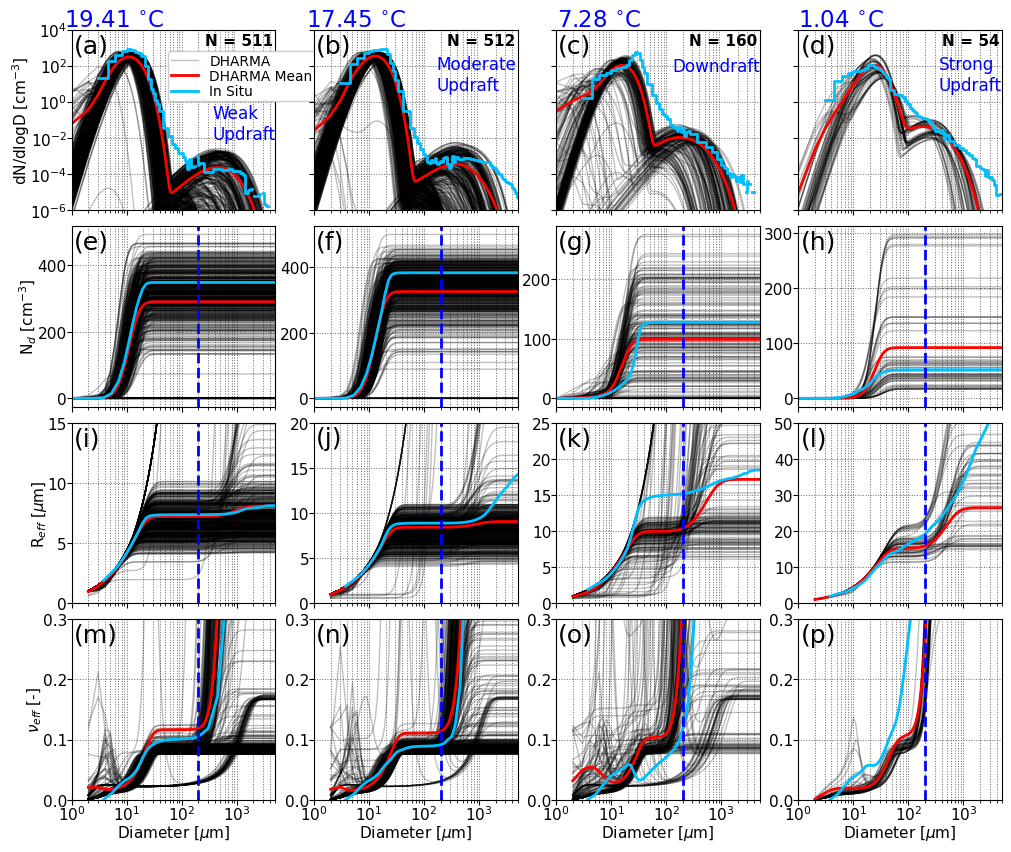

done


In [32]:
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(12,10.))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

axes_flat_1 = axes_flat[0:4]
axes_flat_2 = axes_flat[4:8]
axes_flat_3 = axes_flat[8:12]
axes_flat_4 = axes_flat[12:]

for ax in axes_flat_1:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,5000)
    ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,3,1)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#left_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
left_axes = [axes_flat_1[0]]
dum_ticks = np.arange(-6,6,2)
yticks = []
for dum_tick in dum_ticks:
    yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_yticklabels(yticks)
    ax.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
#axes_flat_1[0].set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    
#bottom_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat_1:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    

#========================================================
# Avg. W (Loop)
#========================================================
dumi=0
for key in avg_w_dNdlogD_dict.keys():
    dNdlogD_arr = avg_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        if ii == 0.:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25,label='DHARMA')
        else:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
            
    axes_flat_1[dumi].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA Mean')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes_flat_1[dumi].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes_flat_1[dumi].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes_flat_1[dumi].transAxes)

    dumi+=1  
    
    
for ii in range(4):
    dumstr = str(np.around(lj_mean_temps[ii],2))+' $^{\\circ}$C'
    axes_flat_1[ii].text(0.21,1.05,dumstr,transform=axes_flat_1[ii].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center')
    

start_int_id = 0


#========================================
# Cumulative Nd
#========================================
for ax in axes_flat_2:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_2[0]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)

#bottom_axes = [axes_flat_2[0],axes_flat[1],axes_flat[2],axes_flat[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(e)','(f)','(g)','(h)']
dumi=0
for ax in axes_flat_2:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
    

dumi=0
for key in avg_w_nd_cum.keys():
    tmp_nd_cum_arr = avg_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_2[dumi].plot(diam_midbins[start_int_id:]*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_2[dumi].plot(diam_midbins[start_int_id:]*1.e6,avg_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_2[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_2:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_2:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')    
    
    
    
    
#========================================================
# Cumulative Reff
#========================================================

for ax in axes_flat_3:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_3[0]]

    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize,labelpad=-1)


if False:
    bottom_axes = [axes_flat_3[0],axes_flat_3[1],axes_flat_3[2],axes_flat_3[3]]
    dum_ticks = np.arange(0,5,1)
    xticks = []
    for dum_tick in dum_ticks:
        xticks.append('10$^{'+str(int(dum_tick))+'}$')

    for ax in bottom_axes:
        ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
        ax.set_xticklabels(xticks)
    
labs = ['(i)','(j)','(k)','(l)']
dumi=0
for ax in axes_flat_3:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    


dumi=0
for key in avg_w_reff_cum.keys():
    tmp_reff_cum_arr = avg_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_3[dumi].plot(diam_midbins[start_int_id:]*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_3[dumi].plot(diam_midbins[start_int_id:]*1.e6,avg_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_3[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_3:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_3:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')

    
axes_flat_3[0].set_ylim(0,15)
axes_flat_3[1].set_ylim(0,20)
axes_flat_3[2].set_ylim(0,25)
axes_flat_3[3].set_ylim(0,50)
        
    
    
#========================================================
# Cumulative Veff
#========================================================

for ax in axes_flat_4:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_4[0]]

    
for ax in left_axes:
    ax.set_ylabel('$\\nu_{eff}$ [-]',fontsize=Fontsize,labelpad=-1)


bottom_axes = [axes_flat_4[0],axes_flat_4[1],axes_flat_4[2],axes_flat_4[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(m)','(n)','(o)','(p)']
dumi=0
for ax in axes_flat_4:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    


dumi=0
for key in avg_w_veff_cum.keys():
    tmp_veff_cum_arr = avg_w_veff_cum[key]
    tmp_reff_cum_arr = avg_w_reff_cum[key]
    num_dsds = len(tmp_veff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_4[dumi].plot(diam_midbins*1.e6,tmp_veff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_4[dumi].plot(diam_midbins*1.e6,avg_w_mean_veff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_4[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_veff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_4:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_4:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')

    
dum_lim = 0.3
axes_flat_4[0].set_ylim(0,dum_lim)
axes_flat_4[1].set_ylim(0,dum_lim)
axes_flat_4[2].set_ylim(0,dum_lim)
axes_flat_4[3].set_ylim(0,dum_lim)    
    
    
    
axes_flat_1[0].legend(loc='upper right',framealpha=True,fontsize=Fontsize*0.9,bbox_to_anchor=(1.23,0.92),labelspacing=0.1,borderpad=0.2)

if False:
    dumstr = 'DSD'
    axes_flat_1[0].text(-0.4,0.5,dumstr,transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
    dumstr = 'Cumulative $N_{d}$'
    axes_flat_2[0].text(-0.35,0.5,dumstr,transform=axes_flat_2[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
    dumstr = 'Cumulative $R_{eff}$'
    axes_flat_3[0].text(-0.35,0.5,dumstr,transform=axes_flat_3[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
    dumstr = 'Cumulative $\\nu_{eff}$'
    axes_flat_4[0].text(-0.35,0.5,dumstr,transform=axes_flat_4[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)

dumstrs = ['Weak\nUpdraft','Moderate\nUpdraft','Downdraft','Strong\nUpdraft']

tmp_c = 'blue'
axes_flat_1[0].text(0.69,0.48,dumstrs[0],transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[1].text(0.6,0.75,dumstrs[1],transform=axes_flat_1[1].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[2].text(0.57,0.8,dumstrs[2],transform=axes_flat_1[2].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[3].text(0.69,0.75,dumstrs[3],transform=axes_flat_1[3].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
    
    
plt.subplots_adjust(wspace=0.19,hspace=0.09)


save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_bulk_cloud_pass_DSDs_cumulatively_integrated_Reff_Veff_Nd.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# ===============================================
# NOTE: Everything below is exploratory, and some
# of it may be broken
# ===============================================

# Plot DSDs for 4 different cloud-pass temperatures for all cloud passes (leftmost column), cloud passes conditioned on avg. W (middle column), and cloud passes conditioned on max. W (rightmost column)
## Each panel has individual cloud-pass DSDs in black, the mean DSD of all cloud passes in red, and the observed DSD in light blue

14
16
8
19


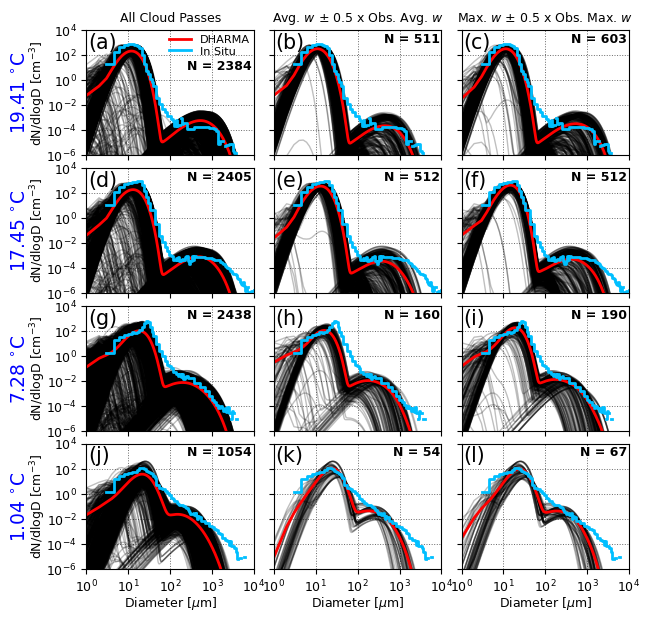

done


In [34]:
fig,axes = plt.subplots(nrows=4,ncols=3,figsize=(7,7))
axes_flat = np.ndarray.flatten(axes)
Fontsize=9

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,1.e4)
    ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

left_axes = [axes_flat[0],axes_flat[3],axes_flat[6],axes_flat[9]]
dum_ticks = np.arange(-6,6,2)
yticks = []
for dum_tick in dum_ticks:
    yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    ax.set_yticklabels(yticks)
    
bottom_axes = [axes_flat[9],axes_flat[10],axes_flat[11]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
dumi=0
for ax in axes_flat:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
axes[0,0].set_title('All Cloud Passes',fontsize=Fontsize*1)
axes[0,1].set_title('Avg. $w$ $\\pm$ 0.5 x Obs. Avg. $w$',fontsize=Fontsize*1)
axes[0,2].set_title('Max. $w$ $\\pm$ 0.5 x Obs. Max. $w$',fontsize=Fontsize*1)
    
    
#========================================================
# All Cloud Passes (Loop)
#========================================================
all_cp_dNdD_dict = {}
all_cp_dNdlogD_dict = {}
if True:
    dumi=0
    
    for key in all_cloud_pass_dict_y.keys():
        print(key)
        tmp_dict = all_cloud_pass_dict_y[key]
        cp_keys = list(tmp_dict.keys())
        # Loop through individual cloud passes to get an array of the DSDs
        dNdD_arr = []
        dNdlogD_arr = []
        for cp_key in cp_keys:
            tmp_dNdD = tmp_dict[cp_key]['dNdD']
            tmp_dNdlogD = tmp_dict[cp_key]['dNdlogD']
            axes[dumi,0].plot(diam_midbins*1.e6,tmp_dNdlogD,c='k',lw=1,alpha=0.25)
            dNdD_arr.append(tmp_dNdD)
            dNdlogD_arr.append(tmp_dNdlogD)
        dNdD_arr = np.array(dNdD_arr)
        dNdlogD_arr = np.array(dNdlogD_arr)
        all_cp_dNdD_dict[key] = dNdD_arr
        all_cp_dNdlogD_dict[key] = dNdlogD_arr
        num_dsds = len(dNdlogD_arr[:,0])
        mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
        axes[dumi,0].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA')

        # Plot learjet
        tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
        tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
        axes[dumi,0].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')
        
        dum_str = 'N = '+str(int(num_dsds))
        if dumi != 0.:
            axes[dumi,0].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes[dumi,0].transAxes)
        else:
            axes[dumi,0].text(0.99,0.76,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes[dumi,0].transAxes)

        dumi+=1
    
axes[0,0].legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.04,1.04),labelspacing=0.1)

#========================================================
# Avg. W (Loop)
#========================================================
dumi=0
for key in avg_w_dNdlogD_dict.keys():
    dNdlogD_arr = avg_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        axes[dumi,1].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
    axes[dumi,1].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes[dumi,1].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes[dumi,1].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes[dumi,1].transAxes)

    dumi+=1          

#========================================================
# Max. W (Loop)
#========================================================
dumi=0
for key in max_w_dNdlogD_dict.keys():
    dNdlogD_arr = max_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        axes[dumi,2].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
    axes[dumi,2].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes[dumi,2].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes[dumi,2].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes[dumi,2].transAxes)

    dumi+=1  
    
    
for ii in range(4):
    dumstr = str(np.around(lj_mean_temps[ii],2))+' $^{\\circ}$C'
    axes[ii,0].text(-0.4,0.5,dumstr,transform=axes[ii,0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
    
plt.subplots_adjust(wspace=0.12,hspace=0.1)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'fig_09.png'
outfile = 'fig_cntl_dsds.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# Plot 4 cloud pass DSDs conditioned on max or avg vertical velocity (uncomment to switch between)

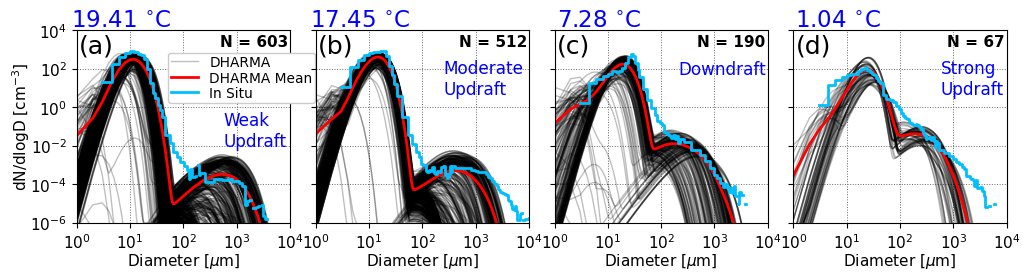

done


In [14]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2.5))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,1.e4)
    ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

left_axes = [axes_flat[0]]
dum_ticks = np.arange(-6,6,2)
yticks = []
for dum_tick in dum_ticks:
    yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    ax.set_yticklabels(yticks)
    
bottom_axes = [axes_flat[0],axes_flat[1],axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
#axes[0,0].set_title('All Cloud Passes',fontsize=Fontsize*1)
#axes[0,1].set_title('Avg. $w$ $\\pm$ 0.5 x Obs. Avg. $w$',fontsize=Fontsize*1)
#axes[0,2].set_title('Max. $w$ $\\pm$ 0.5 x Obs. Max. $w$',fontsize=Fontsize*1)
 
    
#========================================================
# Max. W (Loop)
#========================================================
dumi=0
for key in max_w_dNdlogD_dict.keys():
    dNdlogD_arr = max_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        if ii == 0.:
            axes[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25,label='DHARMA')
        else:
            axes[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
            
    axes[dumi].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA Mean')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes[dumi].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes[dumi].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes[dumi].transAxes)

    dumi+=1  
    
    
for ii in range(4):
    dumstr = str(np.around(lj_mean_temps[ii],2))+' $^{\\circ}$C'
    axes[ii].text(0.21,1.05,dumstr,transform=axes[ii].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center')
    
dumstrs = ['Weak\nUpdraft','Moderate\nUpdraft','Downdraft','Strong\nUpdraft']
#for ii in range(4):
#    dumstr = dumstrs[ii]
#    axes[ii].text(0.6,0.95,dumstr,transform=axes[ii].transAxes,fontsize=Fontsize*1.1,c='k',ha='left',va='center')

#axes[0].text(0.65,1.1,dumstrs[0],transform=axes[0].transAxes,fontsize=Fontsize*1.,c='k',ha='center',va='center')
#axes[1].text(0.65,1.1,dumstrs[1],transform=axes[1].transAxes,fontsize=Fontsize*1.,c='k',ha='center',va='center')
#axes[2].text(0.65,1.1,dumstrs[2],transform=axes[2].transAxes,fontsize=Fontsize*1.,c='k',ha='center',va='center')
#axes[3].text(0.65,1.1,dumstrs[3],transform=axes[3].transAxes,fontsize=Fontsize*1.,c='k',ha='center',va='center')
    
#axes[0].text(0.69,0.75,dumstrs[0],transform=axes[0].transAxes,fontsize=Fontsize*1.1,c='k',ha='left',va='center')
tmp_c = 'blue'
axes[0].text(0.69,0.48,dumstrs[0],transform=axes[0].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes[1].text(0.6,0.75,dumstrs[1],transform=axes[1].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes[2].text(0.58,0.8,dumstrs[2],transform=axes[2].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes[3].text(0.69,0.75,dumstrs[3],transform=axes[3].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
    
#axes[0].legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.04,0.9),labelspacing=0.1)
axes[0].legend(loc='upper right',framealpha=True,fontsize=Fontsize*0.9,bbox_to_anchor=(1.15,0.92),labelspacing=0.1,borderpad=0.2)
#axes[0].legend(loc='upper right',framealpha=False,fontsize=Fontsize*0.9,bbox_to_anchor=(1.2,1.325),labelspacing=0.1)

    
plt.subplots_adjust(wspace=0.12,hspace=0.1)

save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
#outfile = 'fig_09.png'
outfile = 'CNTL_DSDs.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# Plot DSDs and cumulatively integrated Reff, and Nd for cloud passes conditioned on avg or max vertical velocity (uncomment to switch)

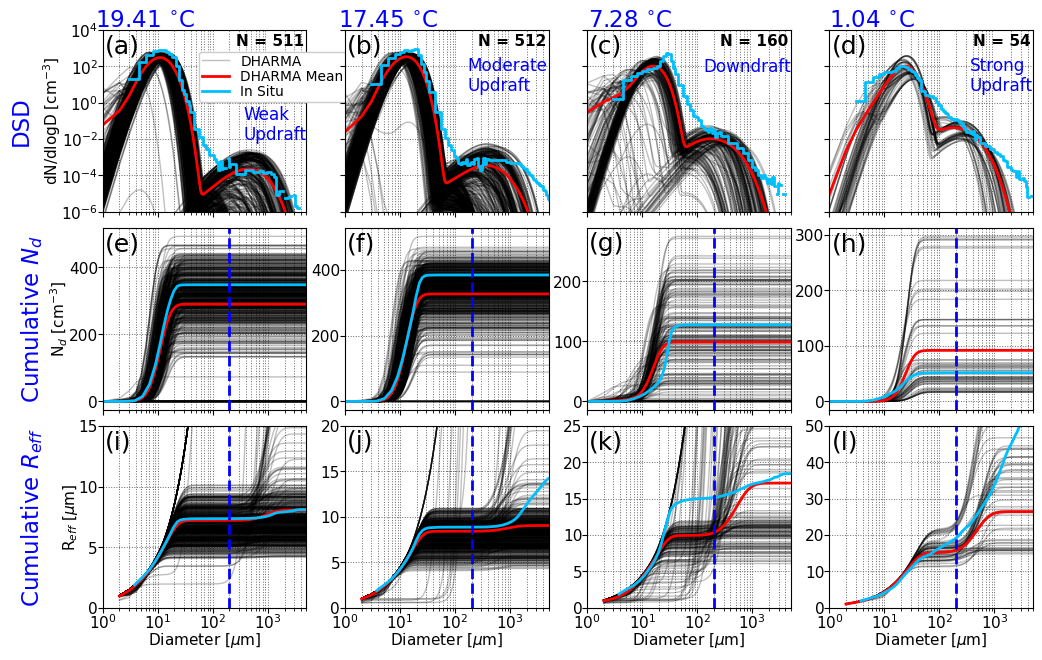

done


In [28]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(12,7.5))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

axes_flat_1 = axes_flat[0:4]
axes_flat_2 = axes_flat[4:8]
axes_flat_3 = axes_flat[8:]

for ax in axes_flat_1:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,5000)
    ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,3,1)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#left_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
left_axes = [axes_flat_1[0]]
dum_ticks = np.arange(-6,6,2)
yticks = []
for dum_tick in dum_ticks:
    yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_yticklabels(yticks)
    ax.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
#axes_flat_1[0].set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    
#bottom_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat_1:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    

#========================================================
# Avg. W (Loop)
#========================================================
dumi=0
for key in avg_w_dNdlogD_dict.keys():
    dNdlogD_arr = avg_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        if ii == 0.:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25,label='DHARMA')
        else:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
            
    axes_flat_1[dumi].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA Mean')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes_flat_1[dumi].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes_flat_1[dumi].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes_flat_1[dumi].transAxes)

    dumi+=1  
    
    
for ii in range(4):
    dumstr = str(np.around(lj_mean_temps[ii],2))+' $^{\\circ}$C'
    axes_flat_1[ii].text(0.21,1.05,dumstr,transform=axes_flat_1[ii].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center')
    



#========================================
# Cumulative Nd
#========================================
for ax in axes_flat_2:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_2[0]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)

#bottom_axes = [axes_flat_2[0],axes_flat[1],axes_flat[2],axes_flat[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(e)','(f)','(g)','(h)']
dumi=0
for ax in axes_flat_2:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
    

dumi=0
for key in avg_w_nd_cum.keys():
    tmp_nd_cum_arr = avg_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_2[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_2[dumi].plot(diam_midbins*1.e6,avg_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_2[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_2:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_2:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')    
    
    
    
    
#========================================================
# Cumulative Reff
#========================================================

for ax in axes_flat_3:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_3[0]]

    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize,labelpad=-1)


bottom_axes = [axes_flat_3[0],axes_flat_3[1],axes_flat_3[2],axes_flat_3[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(i)','(j)','(k)','(l)']
dumi=0
for ax in axes_flat_3:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    


dumi=0
for key in avg_w_reff_cum.keys():
    tmp_reff_cum_arr = avg_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_3[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_3[dumi].plot(diam_midbins*1.e6,avg_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_3[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_3:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_3:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')

    
axes_flat_3[0].set_ylim(0,15)
axes_flat_3[1].set_ylim(0,20)
axes_flat_3[2].set_ylim(0,25)
axes_flat_3[3].set_ylim(0,50)
        
    
axes_flat_1[0].legend(loc='upper right',framealpha=True,fontsize=Fontsize*0.9,bbox_to_anchor=(1.23,0.92),labelspacing=0.1,borderpad=0.2)

dumstr = 'DSD'
axes_flat_1[0].text(-0.4,0.5,dumstr,transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
dumstr = 'Cumulative $N_{d}$'
axes_flat_2[0].text(-0.35,0.5,dumstr,transform=axes_flat_2[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
dumstr = 'Cumulative $R_{eff}$'
axes_flat_3[0].text(-0.35,0.5,dumstr,transform=axes_flat_3[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
   
dumstrs = ['Weak\nUpdraft','Moderate\nUpdraft','Downdraft','Strong\nUpdraft']

tmp_c = 'blue'
axes_flat_1[0].text(0.69,0.48,dumstrs[0],transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[1].text(0.6,0.75,dumstrs[1],transform=axes_flat_1[1].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[2].text(0.57,0.8,dumstrs[2],transform=axes_flat_1[2].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[3].text(0.69,0.75,dumstrs[3],transform=axes_flat_1[3].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
    
    
    
    
plt.subplots_adjust(wspace=0.19,hspace=0.09)



save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
outfile = 'CNTL_DSDs.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# Plot cumulative integrated Reff for each cloud pass. No conditioning (i.e., all cloud passes).

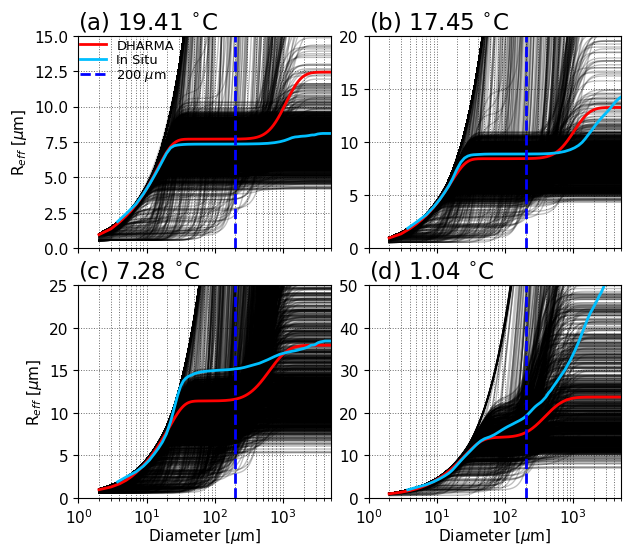

In [22]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_ylim(0,50)
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in all_cp_reff_cum.keys():
    tmp_reff_cum_arr = all_cp_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,all_cp_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    
    
axes_flat[0].set_ylim(0,15)
axes_flat[1].set_ylim(0,20)
axes_flat[2].set_ylim(0,25)
axes_flat[3].set_ylim(0,50)

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
axes_flat[0].legend(loc='upper left',framealpha=False,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.04,1.04),labelspacing=0.1)
    
plt.subplots_adjust(wspace=0.15,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'fig_11.png'
outfile = 'fig_cntl_reff_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot cumulative integrated Nd for each cloud pass. No conditioning (i.e., all cloud passes).

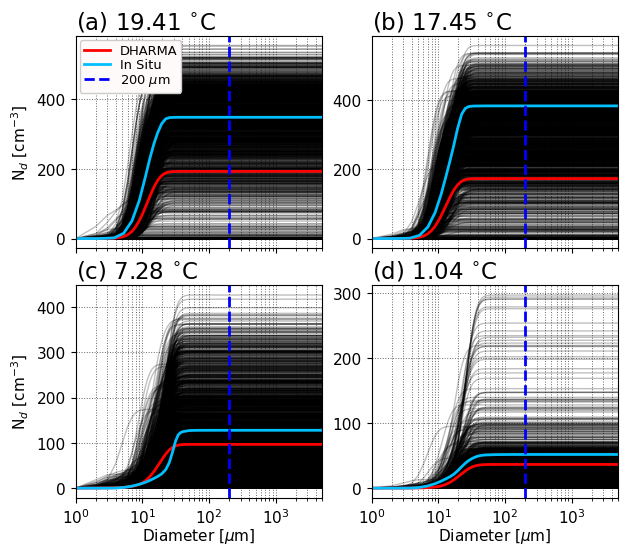

In [23]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in all_cp_nd_cum.keys():
    tmp_nd_cum_arr = all_cp_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,all_cp_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
lgnd = axes_flat[0].legend(loc='upper left',framealpha=True,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.01,1.01),labelspacing=0.1,borderpad=0.3)
frame = lgnd.get_frame()
frame.set_facecolor('snow')

plt.subplots_adjust(wspace=0.2,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_cntl_nd_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot cumulative integrated Reff for each cloud pass. Conditioning on Max. W.

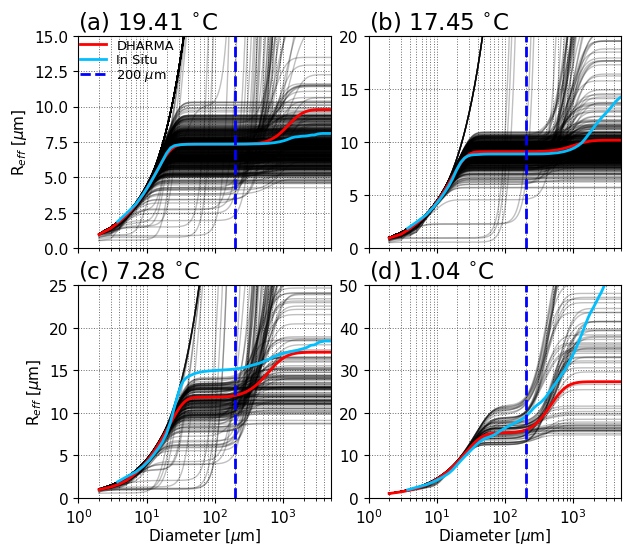

In [24]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_ylim(0,50)
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in max_w_reff_cum.keys():
    tmp_reff_cum_arr = max_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])
   
    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,max_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    
    
axes_flat[0].set_ylim(0,15)
axes_flat[1].set_ylim(0,20)
axes_flat[2].set_ylim(0,25)
axes_flat[3].set_ylim(0,50)

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
axes_flat[0].legend(loc='upper left',framealpha=False,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.04,1.04),labelspacing=0.1)
    
plt.subplots_adjust(wspace=0.15,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'fig_11.png'
outfile = 'fig_cntl_reff_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Cumulative-integrated Nd for Max. W conditioning used for poster

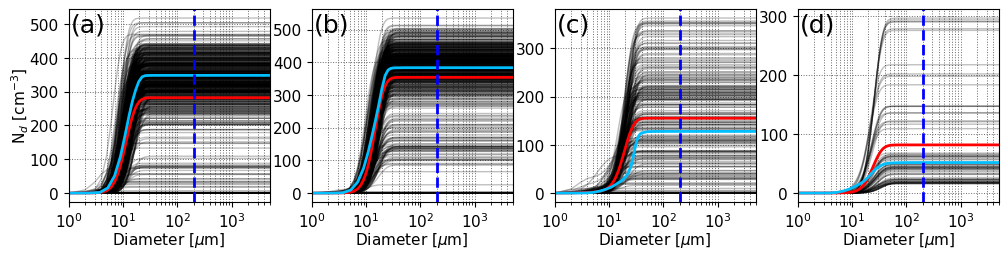

done


In [25]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2.5))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    #ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,5000)
    #ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

left_axes = [axes_flat[0]]
#dum_ticks = np.arange(-6,6,2)
#yticks = []
##for dum_tick in dum_ticks:
 #   yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    #ax.set_yticklabels(yticks)


bottom_axes = [axes_flat[0],axes_flat[1],axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
    


dumi=0
for key in max_w_nd_cum.keys():
    tmp_nd_cum_arr = max_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,max_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat:
    ax.set_xlim(1,5000)
    
for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
    
plt.subplots_adjust(wspace=0.21)

save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
#outfile = 'fig_09.png'
outfile = 'CNTL_int_Nd.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')

# Cumulative-integrated Reff for Max. W conditioning used for poster

In [26]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(12,2.5))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    #ax.set_yscale('log')
    ax.set_xscale('log')
    #ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,5000)
    #ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

left_axes = [axes_flat[0]]
#dum_ticks = np.arange(-6,6,2)
#yticks = []
##for dum_tick in dum_ticks:
 #   yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize,labelpad=-1)
    #ax.set_yticklabels(yticks)


bottom_axes = [axes_flat[0],axes_flat[1],axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
    


dumi=0
for key in max_w_reff_cum.keys():
    tmp_reff_cum_arr = max_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,max_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat:
    ax.set_xlim(1,5000)
    
for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')

    
axes_flat[0].set_ylim(0,15)
axes_flat[1].set_ylim(0,20)
axes_flat[2].set_ylim(0,25)
axes_flat[3].set_ylim(0,50)
    
plt.subplots_adjust(wspace=0.17)

save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
#outfile = 'fig_09.png'
outfile = 'CNTL_int_Reff.png'
plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
#plt.show()
plt.close()
print('done')

done


# Plot cumulative integrated Nd for each cloud pass. Conditioned on Max. W.
## Not used in manuscript.

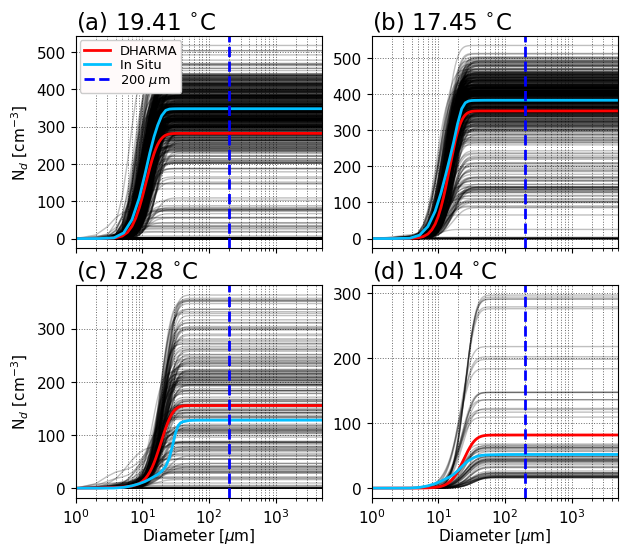

In [27]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in max_w_nd_cum.keys():
    tmp_nd_cum_arr = max_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,max_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
lgnd = axes_flat[0].legend(loc='upper left',framealpha=True,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.01,1.01),labelspacing=0.1,borderpad=0.3)
frame = lgnd.get_frame()
frame.set_facecolor('snow')

plt.subplots_adjust(wspace=0.2,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_cntl_nd_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot cumulative integrated Reff for each cloud pass. Conditioning on Avg. W.
## Not used in manuscript.

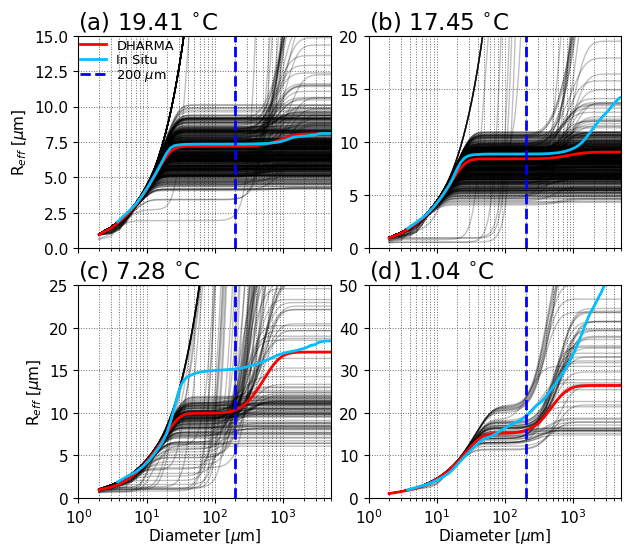

In [28]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_ylim(0,50)
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in avg_w_reff_cum.keys():
    tmp_reff_cum_arr = avg_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,avg_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    
    
axes_flat[0].set_ylim(0,15)
axes_flat[1].set_ylim(0,20)
axes_flat[2].set_ylim(0,25)
axes_flat[3].set_ylim(0,50)

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
axes_flat[0].legend(loc='upper left',framealpha=False,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.04,1.04),labelspacing=0.1)
    
plt.subplots_adjust(wspace=0.15,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
#outfile = 'fig_11.png'
outfile = 'fig_cntl_reff_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot cumulative integrated Nd for each cloud pass. Conditioned on Avg. W.
## Not used in manuscript.

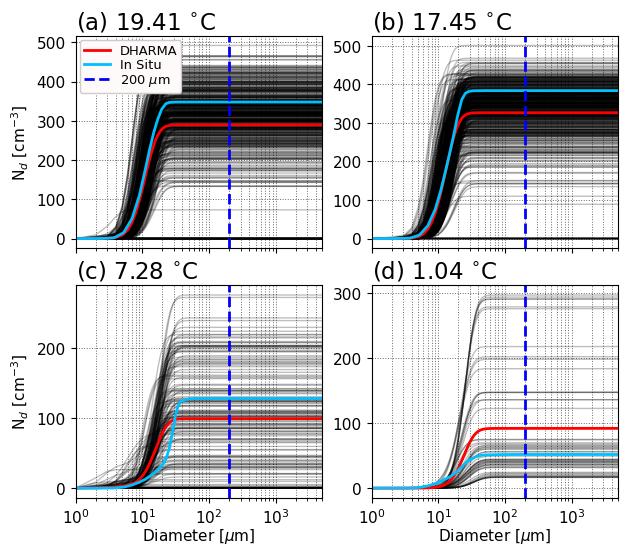

In [29]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(7,6))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

for ax in axes_flat:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,4,1)))
    ax.set_xticklabels([])
    #ax.set_yticklabels([])

left_axes = [axes_flat[0],axes_flat[2]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize)
    
bottom_axes = [axes_flat[2],axes_flat[3]]
dum_ticks = np.arange(0,4,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat:
    dumstr = labs[dumi]+' '+str(np.around(lj_mean_temps[dumi],2))+' $^{\\circ}$C'
    ax.text(0.,1.125,dumstr,transform=ax.transAxes,fontsize=Fontsize*1.5,ha='left',va='top')
    dumi+=1
    

dumi=0
for key in avg_w_nd_cum.keys():
    tmp_nd_cum_arr = avg_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat[dumi].plot(diam_midbins*1.e6,avg_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')
    
lgnd = axes_flat[0].legend(loc='upper left',framealpha=True,fontsize=Fontsize*0.85,bbox_to_anchor=(-0.01,1.01),labelspacing=0.1,borderpad=0.3)
frame = lgnd.get_frame()
frame.set_facecolor('snow')

plt.subplots_adjust(wspace=0.2,hspace=0.175)

save_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_cntl_nd_cumulative.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()

# Plot DSDs and cumulatively integrated Reff and Nd

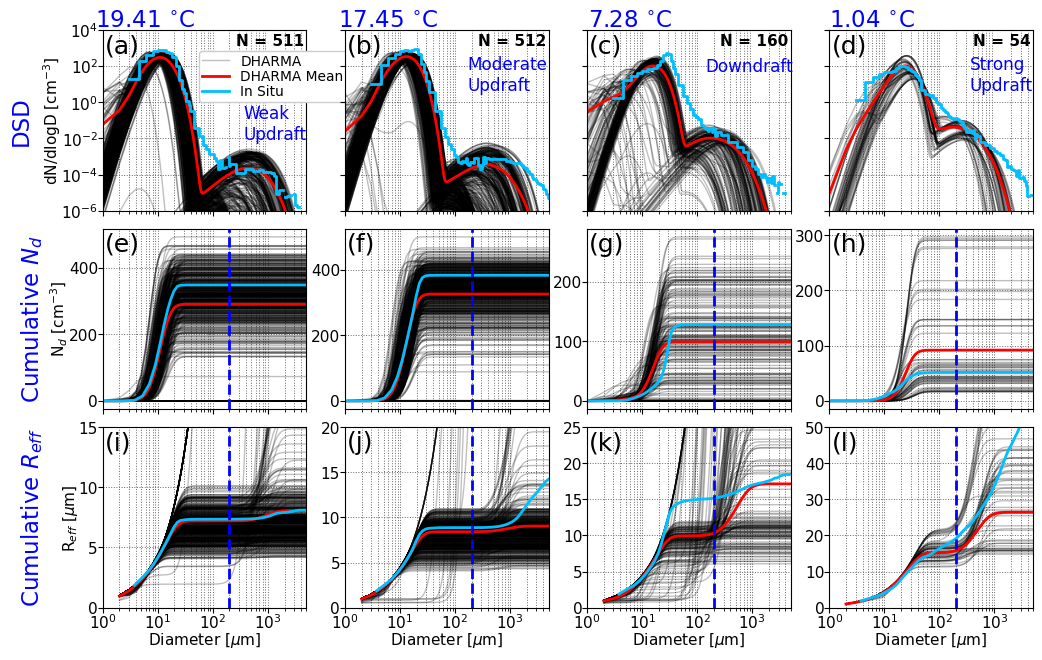

done


In [27]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(12,7.5))
axes_flat = np.ndarray.flatten(axes)
Fontsize=11

axes_flat_1 = axes_flat[0:4]
axes_flat_2 = axes_flat[4:8]
axes_flat_3 = axes_flat[8:]

for ax in axes_flat_1:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim(1.e-6,1.e4)
    ax.set_xlim(1,5000)
    ax.set_yticks(10.**(np.arange(-6,6,2)))
    ax.set_xticks(10.**(np.arange(0,3,1)))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#left_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
left_axes = [axes_flat_1[0]]
dum_ticks = np.arange(-6,6,2)
yticks = []
for dum_tick in dum_ticks:
    yticks.append('10$^{'+str(int(dum_tick))+'}$')
    
for ax in left_axes:
    ax.set_yticklabels(yticks)
    ax.set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
#axes_flat_1[0].set_ylabel('dN/dlogD [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)
    
#bottom_axes = [axes_flat_1[0],axes_flat_1[1],axes_flat_1[2],axes_flat_1[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(a)','(b)','(c)','(d)']
dumi=0
for ax in axes_flat_1:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    

#========================================================
# Avg. W (Loop)
#========================================================
dumi=0
for key in avg_w_dNdlogD_dict.keys():
    dNdlogD_arr = avg_w_dNdlogD_dict[key]
    mean_dNdlogD = np.mean(dNdlogD_arr,axis=0)
    num_dsds = len(dNdlogD_arr[:,0])
    for ii in range(num_dsds):
        if ii == 0.:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25,label='DHARMA')
        else:
            axes_flat_1[dumi].plot(diam_midbins*1.e6,dNdlogD_arr[ii,:],c='k',lw=1,alpha=0.25)
            
    axes_flat_1[dumi].plot(diam_midbins*1.e6,mean_dNdlogD,c='red',lw=2,label='DHARMA Mean')

    # Plot learjet
    tmp_lj_dNdlogD = learjet_dict[key]['comp']['dNdlogD']
    tmp_lj_sizes = learjet_dict[key]['comp']['sizes']
    axes_flat_1[dumi].step(tmp_lj_sizes,tmp_lj_dNdlogD*1.e-3,c='deepskyblue',lw=2,label='In Situ',where='mid')

    dum_str = 'N = '+str(int(num_dsds))
    axes_flat_1[dumi].text(0.99,0.98,dum_str,fontsize=Fontsize,fontweight='bold',ha='right',va='top',transform=axes_flat_1[dumi].transAxes)

    dumi+=1  
    
    
for ii in range(4):
    dumstr = str(np.around(lj_mean_temps[ii],2))+' $^{\\circ}$C'
    axes_flat_1[ii].text(0.21,1.05,dumstr,transform=axes_flat_1[ii].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center')
    
dumstrs = ['Weak\nUpdraft','Moderate\nUpdraft','Downdraft','Strong\nUpdraft']

tmp_c = 'blue'
axes_flat_1[0].text(0.69,0.48,dumstrs[0],transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[1].text(0.6,0.75,dumstrs[1],transform=axes_flat_1[1].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[2].text(0.58,0.8,dumstrs[2],transform=axes_flat_1[2].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
axes_flat_1[3].text(0.69,0.75,dumstrs[3],transform=axes_flat_1[3].transAxes,fontsize=Fontsize*1.1,c=tmp_c,ha='left',va='center')
    



#========================================
# Cumulative Nd
#========================================
for ax in axes_flat_2:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_2[0]]
    
for ax in left_axes:
    ax.set_ylabel('N$_{d}$ [cm$^{-3}$]',fontsize=Fontsize,labelpad=-1)

#bottom_axes = [axes_flat_2[0],axes_flat[1],axes_flat[2],axes_flat[3]]
#dum_ticks = np.arange(0,5,1)
#xticks = []
#for dum_tick in dum_ticks:
#    xticks.append('10$^{'+str(int(dum_tick))+'}$')

#for ax in bottom_axes:
#    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
#    ax.set_xticklabels(xticks)
    
labs = ['(e)','(f)','(g)','(h)']
dumi=0
for ax in axes_flat_2:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    
    

dumi=0
for key in avg_w_nd_cum.keys():
    tmp_nd_cum_arr = avg_w_nd_cum[key]
    num_dsds = len(tmp_nd_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_2[dumi].plot(diam_midbins*1.e6,tmp_nd_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_2[dumi].plot(diam_midbins*1.e6,avg_w_mean_nd_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_2[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_nd_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_2:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_2:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')    
    
    
    
    
#========================================================
# Cumulative Reff
#========================================================

for ax in axes_flat_3:
    ax.grid(which='both',lw=0.7,ls='dotted',c='dimgrey')
    ax.tick_params(labelsize=Fontsize,pad=0)
    ax.set_xscale('log')
    ax.set_xlim(1,5000)
    ax.set_xticks(10.**(np.arange(0,5,1)))
    ax.set_xticklabels([])

left_axes = [axes_flat_3[0]]

    
for ax in left_axes:
    ax.set_ylabel('R$_{eff}$ [$\\mu$m]',fontsize=Fontsize,labelpad=-1)


bottom_axes = [axes_flat_3[0],axes_flat_3[1],axes_flat_3[2],axes_flat_3[3]]
dum_ticks = np.arange(0,5,1)
xticks = []
for dum_tick in dum_ticks:
    xticks.append('10$^{'+str(int(dum_tick))+'}$')

for ax in bottom_axes:
    ax.set_xlabel('Diameter [$\\mu$m]',fontsize=Fontsize,labelpad=-0.15)  
    ax.set_xticklabels(xticks)
    
labs = ['(i)','(j)','(k)','(l)']
dumi=0
for ax in axes_flat_3:
    ax.text(0.01,0.98,labs[dumi],transform=ax.transAxes,fontsize=Fontsize*1.65,ha='left',va='top')
    dumi+=1
    


dumi=0
for key in avg_w_reff_cum.keys():
    tmp_reff_cum_arr = avg_w_reff_cum[key]
    num_dsds = len(tmp_reff_cum_arr[:,0])

    for ii in range(num_dsds):
        axes_flat_3[dumi].plot(diam_midbins*1.e6,tmp_reff_cum_arr[ii,:],c='k',alpha=0.25,lw=1)

    axes_flat_3[dumi].plot(diam_midbins*1.e6,avg_w_mean_reff_cum[key],c='red',lw=2,label='DHARMA')
    axes_flat_3[dumi].plot(learjet_dict[key]['comp']['sizes'],lj_reff_cum[dumi],c='deepskyblue',lw=2,label='In Situ')
    dumi+=1
    

for ax in axes_flat_3:
    ax.set_xlim(1,5000)
    
for ax in axes_flat_3:
    ax.axvline(200,lw=2,c='blue',ls='dashed',label='200 $\\mu$m')

    
axes_flat_3[0].set_ylim(0,15)
axes_flat_3[1].set_ylim(0,20)
axes_flat_3[2].set_ylim(0,25)
axes_flat_3[3].set_ylim(0,50)
        
    
axes_flat_1[0].legend(loc='upper right',framealpha=True,fontsize=Fontsize*0.9,bbox_to_anchor=(1.23,0.92),labelspacing=0.1,borderpad=0.2)

dumstr = 'DSD'
axes_flat_1[0].text(-0.4,0.5,dumstr,transform=axes_flat_1[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
dumstr = 'Cumulative $N_{d}$'
axes_flat_2[0].text(-0.35,0.5,dumstr,transform=axes_flat_2[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
dumstr = 'Cumulative $R_{eff}$'
axes_flat_3[0].text(-0.35,0.5,dumstr,transform=axes_flat_3[0].transAxes,fontsize=Fontsize*1.5,c='blue',ha='center',va='center',rotation=90)
   
plt.subplots_adjust(wspace=0.19,hspace=0.1)



save_path = '/discover/nobackup/mwstanfo/figures/micro2macro_poster/'
outfile = 'CNTL_DSDs.png'
#plt.savefig(save_path+outfile,dpi=200,bbox_inches='tight')
plt.show()
plt.close()
print('done')